# Python-Based RRKM code (test version)

So far this code work for single steps, and does not include rotational energies.

**Missing features** (to be implemented):

- Capture theory block (translational states)
- Rotational energy (J's) -- **To be done**
- Master equation -- **Working on it**
- Anharmonic vibrational density/sum of states (Witten-Rabinovitch) -- Not included, not projected

Developed by: **Joan Enrique-Romero** (Universitat Autonoma de Barcelona & IPAG, Université Grenoble Alpes), member of the ERC funded DOC and QuantumGrain projects (PId by C. Ceccarelli and A. Rimola, respectively).

Based on the inhouse developed code by Dimitrios Skouteris + bilbiography and needs.

NB: there are 2 local repositories, `my_CALC_functions` and `my_PLOTTING_functions`, which contain most of the functions to be used for calculations and or plotting. The plotting ones were made for my own purposes so you may want to make your own.

## System for testing:

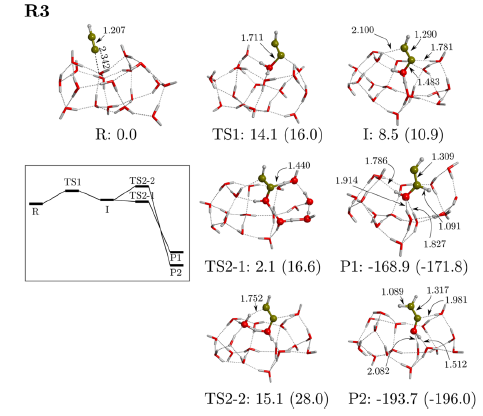

## Input

Generate an input file following these rules:

- There are 2 types of sections:```-- GLOBAL --``` and ``` -- STEP i --```
- Each section contains variable names and values, they are spearated by a semincolon ``` : ```
- Comments with ``` # ```
- Some variables need/allow more than one input, sperate them with a comma ``` , ```
- Example:

```
-- GLOBAL --
dE (kJ/mol):       0.01
nEpts (int):       15000
Ein (kJ/mol):      0.01
Emin (kJ/mol):     0.0
maxT (int, K):     150
num_steps (int):   3
ROT_Dens (Rot in DensStat?, Bool):  True
TUN (tunnel?,all,no*,nrs steps): all  
dir_out (str,path): OUT_TEST
ME: True # True/False <------------------- TBD
Printing_level: simple, debug/high
Sanity_Check: True/False
#----------------------------------------------------------------------
-- STEP 1 --
name (str):            HCO_Christian
vibr_rg (str,path):    INP/FRQS_R_CO_Hydr.txt, 1
vibr_ts (str,path):    INP/FRQS_R_CO_Hydr.txt, 2
Rct_rg (floats, GHz):  0.18784, 0.13383, 0.10628
Rct_ts (floats, GHz):  0.18826, 0.13386, 0.10573
Erg (float,kJ/mol):    0.0
Ets (float,kJ/mol):    11.42830265500080
Epr (float,kJ/mol):    -89.5322280099476
#----------------------------------------------------------------------
-- STEP 2 --
...
...
```

In [40]:
#### Importing packages and defining some variables

import numpy as np
import math, time, importlib, sys
from numba import jit, objmode
import matplotlib.pylab as plt
sys.path.append("/Users/enriquej/Desktop/CALC/Python/myRRKM/LATEST_VERSION")
#
# importlib.reload(sys.modules['my_CALC_functions'])
# importlib.reload(sys.modules['my_PLOTTING_functions'])
# importlib.reload(sys.modules['my_IO_functions'])

import my_CALC_functions as kinCALC
import my_PLOTTING_functions as kinPLOT
import my_IO_functions as kinIO
#
#### --- --- --- Modify cell widths for better confort
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
##
##
#### --- --- --- Some constants and conversion factors
NA          = kinCALC.phys_constants('NA',printing=True)
c           = kinCALC.phys_constants('c',printing=True)
h           = kinCALC.phys_constants('h',printing=True)  # 6.62607004e-34 # Js
har_to_cm1  = kinCALC.convert_Eunits('har','cm1')
kJmol_to_J  = kinCALC.convert_Eunits('kJ/mol','J')
J_to_cm1    = kinCALC.convert_Eunits('J','cm1')
kJmol_to_cm1= kinCALC.convert_Eunits('kJ/mol','cm1')
har_to_J    = kinCALC.convert_Eunits('har','J')

NA = 6.02214076e+23 mol-1
c = 29979245800.0 cm s-1
h = 6.62607015e-34 Js


In [48]:
GLOBALS, DATA_STEPS = kinIO.READ_INPUT("/Users/enriquej/Desktop/CALC/Python/myRRKM/MasterEq_testing/CCH_R3_barr.dat")
kinCALC.GLOBALS = GLOBALS # passing globals to CALC
#globals()['G'] = GLOBALS

#print(GLOBALS)
print(globals()["GLOBALS"])
#print(DATA_STEPS)

NOTE: kJ/mol were converted into cm-1
{'dE': 4.179672696273267, 'nEpts': 3000, 'Ein': 4.179672696273267, 'Emin': 0.0, 'maxT': 150, 'num_steps': 4, 'ROT_Dens': True, 'TUN': [2, 3], 'dir_out': 'OUT_Master_Test_3000', 'Printing_level': 'D', 'Sanity_Check': False}


## Run the code

- The Beyer-Swinehart algorithm can be reached with the function 

   ```BeyerSwinehart(E_grid,NormModes,E_StatPoint,nEpts,dE,Ein,Emin,dens=np.array([None]))```
    
   Where ```E_StatPoint``` is the energy of the PES item (reactants/ts), and ```dens``` could be a previously calculated/initiated Density/Sum of states. For example, one could feed in the rotational density/sum of states. On the other hand, one could introduce an array of the length of E_grid, filled only with 1.0, this way one would obtain a pure vibrational sum of states.


- From a denisty of states, one can calculate a Sum of states by using the ```Sum_States``` function:

    ```Sum_States(E_grid,dens,barrier_E,bkg_barrier_E,dE,Ein,Emin,tn=False,ts_frq=0)```
    
    Where ```barrier_E``` and ```bkg_barrier_E``` are the forward and backward reaction barriers. The backward one is only necessary when tunnelling is desired, which then takes an asymmetric Eckart potential. For that make sure to have ```tn=True``` and to add the frequency of the TS: ```ts_frq```. Notice that if tunneling is set on and no backward barrier is given, the code will automatically adopt a symmetric Eckart potential.

--------------

- In order to calculate the k(E) run ```micocan_kE(N,p,nEpts)``` where `p` is the density of states of reagents and `N` the sum of states of the TS.

- Then you will need to calculate the partition function with `calculate_part_function(E_grid,dens,maxT,nEpts)`.

- Finally the k(T) with `calcuate_rate_T(E_grid,kE,dens,maxT,PF,nEpts)` where PF is the partition function.

--------------

All the functions provide timings.

In [49]:
%%time
#Main loop
print("Starting calculation...")

for istep, STEP in enumerate(DATA_STEPS[:]):
    
    time_step = time.time()
    if GLOBALS["Printing_level"]=='D': print("Step {}/{}".format(istep+1,len(DATA_STEPS)))
    
    ##------ Preparing E_grid
    nEbts_barr = kinCALC.round_numb(STEP['Ets']/GLOBALS['dE'])
    nEpts_TOT  = GLOBALS['nEpts']+nEbts_barr
    E_grid     = kinCALC.make_Egrid(GLOBALS["Ein"],GLOBALS["dE"],nEpts_TOT)
    
    ##------ Densities and sums of states
    if GLOBALS["Printing_level"]=="D":print(" # Running Density of States for reactants and ts...")
    d0_rg, d0_ts = np.array([-1]),np.array([-1])
    if GLOBALS["ROT_Dens"]:
        d0_rg, d0_ts = kinCALC.rot_dens(E_grid,STEP['Erg'],STEP['Rct_rg']), kinCALC.rot_dens(E_grid,STEP['Ets'], STEP['Rct_ts'])
    dens_rg  = kinCALC.BeyerSwinehart(E_grid,STEP['vibr_rg'][ :],STEP['Erg'],nEpts=nEpts_TOT,dens=d0_rg)
    dens_ts  = kinCALC.BeyerSwinehart(E_grid,STEP['vibr_ts'][1:],STEP['Ets'],nEpts=nEpts_TOT,dens=d0_ts)
    
    if GLOBALS["Printing_level"]=='D': print(" # Running Sums of States for ts...")
    sumts_integ = kinCALC.Sum_States(E_grid,dens_ts,barrier_E=STEP['Ets'])
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]:
        sumts_integ_tun = kinCALC.Sum_States(E_grid,dens_ts,barrier_E=STEP['Ets'],bkg_barrier_E=(STEP['Ets']-STEP['Epr']),tn=True,ts_frq=STEP['vibr_ts'][0])
    
    dens_init_BS_ts = np.zeros(nEpts_TOT) # exact count
    for i, d in enumerate(dens_init_BS_ts):
        if i >= kinCALC.find_bin(STEP['Ets'],GLOBALS['dE'],E_grid): dens_init_BS_ts[i]=1.0
    sumts_bs = kinCALC.BeyerSwinehart(E_grid,STEP['vibr_ts'][1:],STEP['Ets'],nEpts=nEpts_TOT,dens=dens_init_BS_ts)
    
    ##------ K(E) and K(T) calculation
    if GLOBALS["Printing_level"]=='D': print(" # Running kE and kT calculations...")
    kE = kinCALC.micocan_kE(N=sumts_integ,p=dens_rg)
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]:
        kE_tun = kinCALC.micocan_kE(N=sumts_integ_tun,p=dens_rg)
    kE_bs = kinCALC.micocan_kE(N=sumts_bs, p=dens_rg)
    
    PartFun = kinCALC.calculate_part_function(E_grid,dens=dens_rg)
    
    kT = kinCALC.calcuate_rate_T(E_grid,kE=kE ,dens=dens_rg,PF=PartFun)
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]:
        kT_tun = kinCALC.calcuate_rate_T(E_grid,kE=kE_tun,dens=dens_rg,PF=PartFun)
    kT_bs = kinCALC.calcuate_rate_T(E_grid,kE=kE_bs ,dens=dens_rg,PF=PartFun)
    
    #------ STORING DATA
    STEP["E_grid"]  = E_grid
    STEP["dens_rg"] = dens_rg
    STEP["dens_ts"] = dens_ts
    STEP["sumts_integ"] = sumts_integ
    STEP["sumts_bs"] = sumts_bs
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]: 
        STEP["sumts_integ_tun"] = sumts_integ_tun
    #
    STEP["kE"] = kE
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]: 
        STEP["kE_tun"] = kE_tun
    STEP["PartFun"] = PartFun
    STEP["kT"] = kT
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]:
        STEP["kT_tun"] = kT_tun
    STEP["kE_bs"] = kE_bs
    STEP["kT_bs"] = kT_bs

    # SANITY CHECKs
    if GLOBALS['Sanity_Check']:
        kinCALC.SanityCheck(GLOBALS['maxT'],STEP)
    
    print(" ---- Step {}/{} took {:.2f} s".format(istep+1,len(DATA_STEPS),time.time()-time_step))
    
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]:
        kinIO.STORE_into_CSV(path=GLOBALS['dir_out']+"/{}_dens_states.csv".format(STEP['name']),
                       cols=[E_grid[:GLOBALS['nEpts']]/J_to_cm1,dens_rg[:GLOBALS['nEpts']]*J_to_cm1,dens_ts[:GLOBALS['nEpts']]*J_to_cm1],
                       header='E[J],    dens_rg[J-1],    dens_ts[J-1]')
        kinIO.STORE_into_CSV(path=GLOBALS['dir_out']+"/{}_sum_states.csv".format(STEP['name']),
                          cols=[E_grid[:GLOBALS['nEpts']]/J_to_cm1,sumts_integ[:GLOBALS['nEpts']],sumts_integ_tun[:GLOBALS['nEpts']]],
                          header='E[J],    sum_states,    sum_states_tun')
        kinIO.STORE_into_CSV(path=GLOBALS['dir_out']+"/{}_kE.csv".format(STEP['name']),
                       cols=[E_grid[:GLOBALS['nEpts']]/J_to_cm1,kE[:GLOBALS['nEpts']],kE_tun[:GLOBALS['nEpts']]],
                       header='E[J],    kE[s-1],    kE_tun')
        kinIO.STORE_into_CSV(path=GLOBALS['dir_out']+"/{}_kT.csv".format(STEP['name']),
                       cols=[np.array([i+1 for i in range(GLOBALS["maxT"])]),np.array([1./(i+1.) for i in range(GLOBALS["maxT"])]),kT,kT_tun],
                       header='T[K],    1/T[K-1],    kT[s-1],    kT_tun')
        kinIO.STORE_into_CSV(path=GLOBALS['dir_out']+"/{}_PartFn.csv".format(STEP['name']),
                       cols=[np.array([i+1 for i in range(GLOBALS["maxT"])]),PartFun*J_to_cm1],
                       header='T[K],    PartFn[J-1]')


        
        # part fn in dens units (1/cm-1), convert into 1/J (*J_to_cm1)
        
print('Done\n')




Starting calculation...
Step 1/4
 # Running Density of States for reactants and ts...
 >> Rot dens took: 0.00 s
 >> Rot dens took: 0.00 s
 >> Beyer-Swinehart algorithm took: 0.00 s
 >> Beyer-Swinehart algorithm took: 0.00 s
 # Running Sums of States for ts...
 >> Numerical sum of states took: 0.51 s
 >> Beyer-Swinehart algorithm took: 0.00 s
 # Running kE and kT calculations...
 >> Numerical partition function took: 0.00 s
 >> Boltzmann averaging to get k(T) took: 0.00 s
 >> Boltzmann averaging to get k(T) took: 0.00 s
 ---- Step 1/4 took 0.53 s
Step 2/4
 # Running Density of States for reactants and ts...
 >> Rot dens took: 0.00 s
 >> Rot dens took: 0.00 s
 >> Beyer-Swinehart algorithm took: 0.00 s
 >> Beyer-Swinehart algorithm took: 0.00 s
 # Running Sums of States for ts...
 >> Numerical sum of states took: 0.73 s
 >> Beyer-Swinehart algorithm took: 0.00 s
 # Running kE and kT calculations...
 >> Numerical partition function took: 0.00 s
 >> Boltzmann averaging to get k(T) took: 0.0

In [7]:
DATA_STEPS[2].keys()


dict_keys(['name', 'vibr_rg', 'vibr_ts', 'Rct_rg', 'Rct_ts', 'Erg', 'Ets', 'Epr', 'E_grid', 'dens_rg', 'dens_ts', 'sumts_integ', 'sumts_bs', 'sumts_integ_tun', 'kE', 'kE_tun', 'PartFun', 'kT', 'kT_tun', 'kE_bs', 'kT_bs'])

## Plotting

STEP 1/4: R3_R-TS1-I1


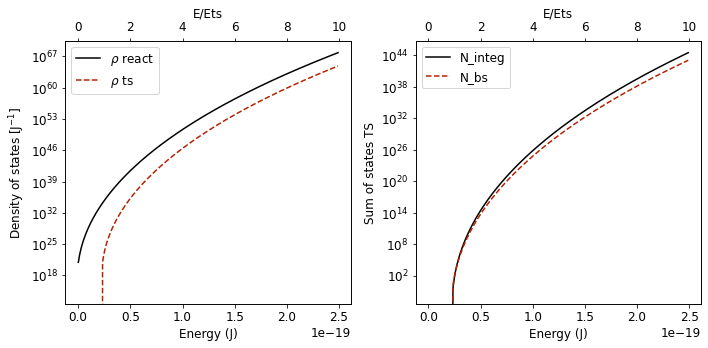

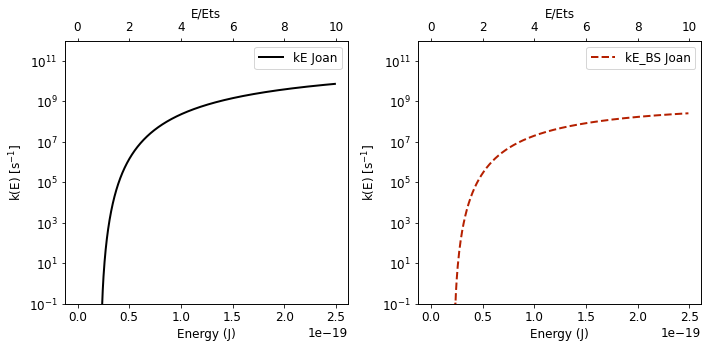

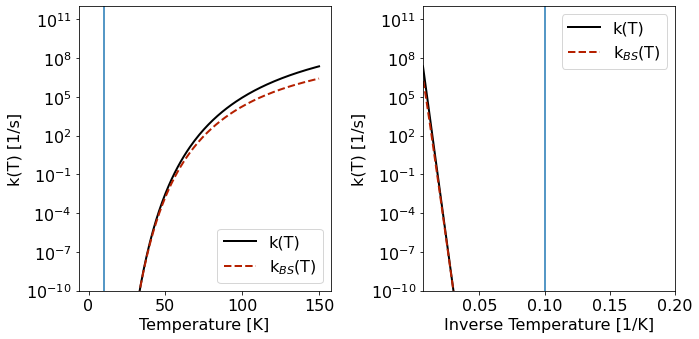

STEP 2/4: R3_I1-TS1-R


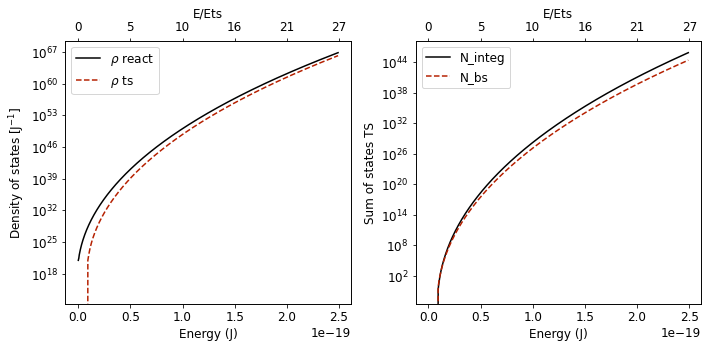

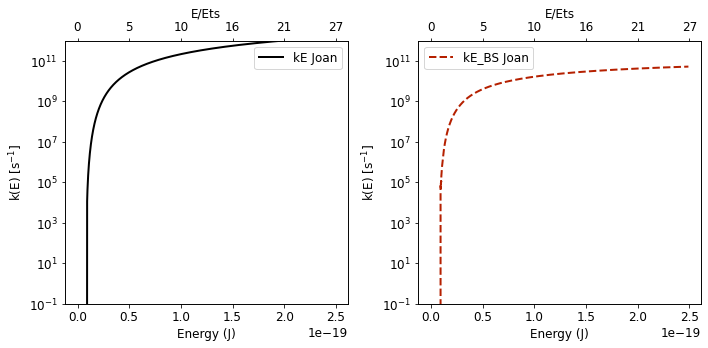

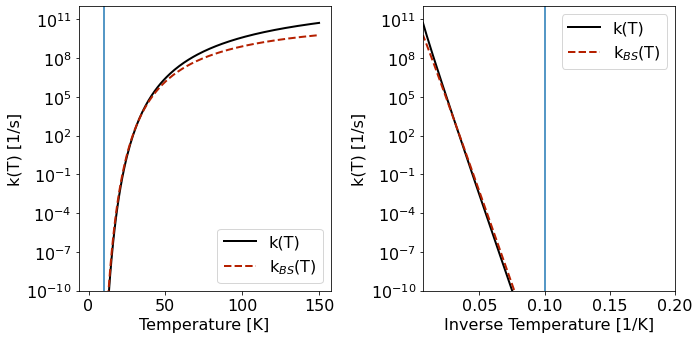

STEP 3/4: R3_I1-TS22-P2


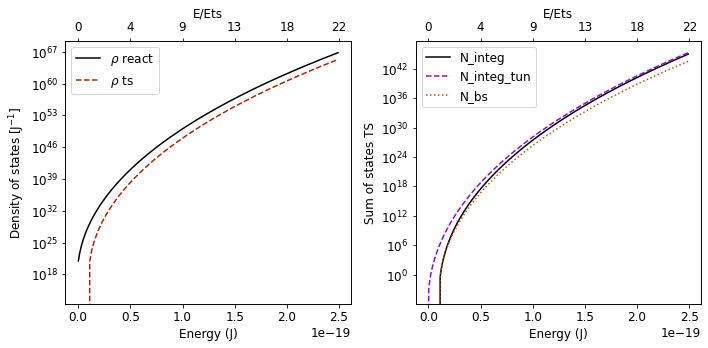

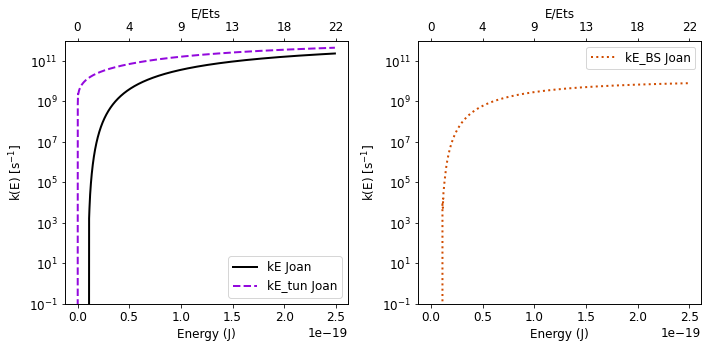

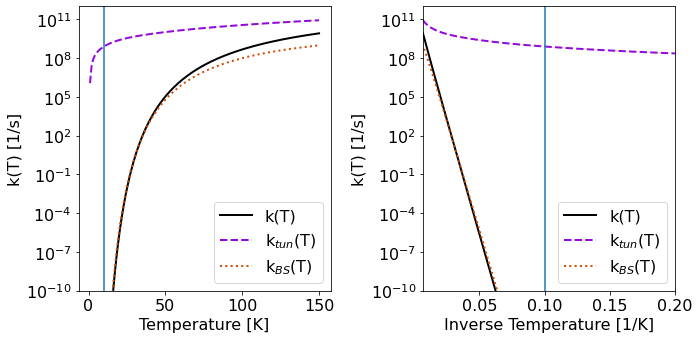

>> Tun probab took: 0.00 s


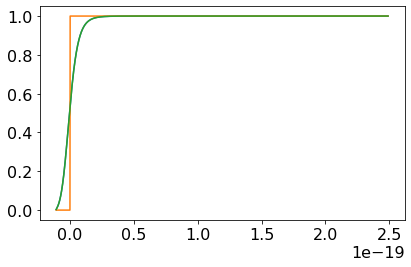

STEP 4/4: R3_P2_TS22_I1
could not use log scale!


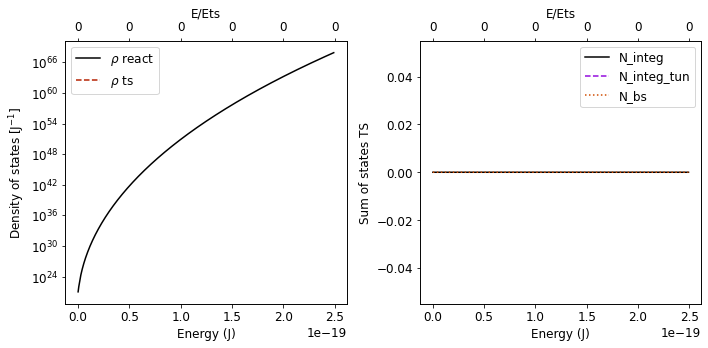

could not use log scale!
could not use log scale!


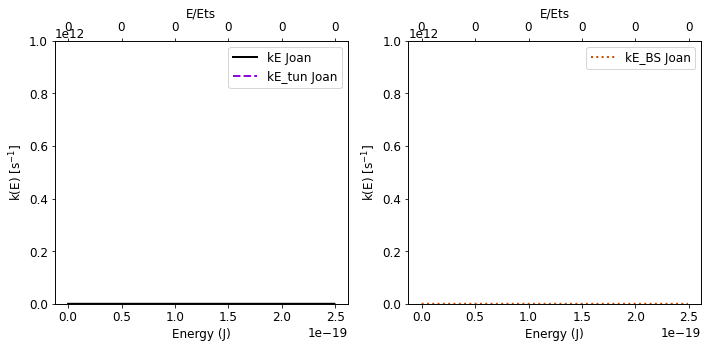

Could not use log scale!
Could not use log scale!


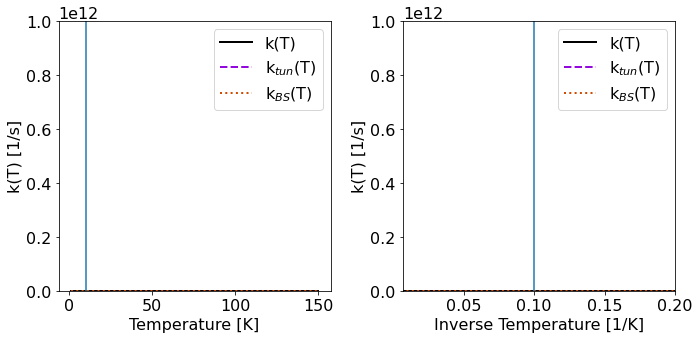

>> Tun probab took: 0.00 s


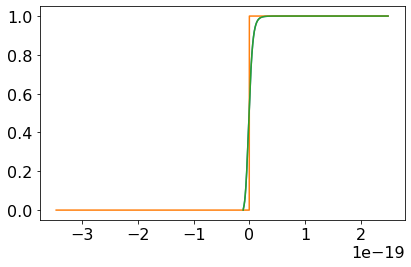

In [50]:
#%matplotlib notebook
%matplotlib inline
def add_Xaxis_EoverEref(ax,Eref):
    # ax must be a list
    dummy_axes = [ax[0].twiny(),ax[1].twiny()]
    for i in [0,1]:
        dummy_axes[i].set_xticks( ax[i].get_xticks() )
        dummy_axes[i].set_xbound( ax[i].get_xbound() )
        dummy_axes[i].set_xticklabels( [int(e/Eref) for e in ax[i].get_xticks()])
        dummy_axes[i].set_xlabel("E/Ets")
def theta(E_grid,v0):
    result = np.zeros(len(E_grid))
    for i,e in enumerate(E_grid):
        if e>v0: result[i]=1.
    return result

for istep,STEP in enumerate(DATA_STEPS[:]):
    print('STEP {}/{}: {}'.format(istep+1,len(DATA_STEPS),STEP['name']))
    ##################################
    ##------ PLOT dens and sum of states
    ##################################
    lisD  = [STEP['dens_rg'],STEP['dens_ts']]
    lisnD = [r"$\rho$ react",r"$\rho$ ts"]
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]:
        lisS  = [STEP['sumts_integ'],STEP['sumts_integ_tun'],STEP['sumts_bs']]
        lisnS = ["N_integ","N_integ_tun","N_bs"]
    else:
        lisS  = [STEP['sumts_integ'],STEP['sumts_bs']]
        lisnS = ["N_integ","N_bs"]

    if GLOBALS["Printing_level"] == "D":
        r_N_axs = kinPLOT.plot_rho_and_N(STEP['E_grid'] / J_to_cm1,lisD,lisnD,lisS,lisnS,GLOBALS['nEpts'],Xaxis_label="Energy (J)",conv_units='cm1_to_J')#,Sk_tot_dens=Sk_tot_dens[istep])
        # Upper X axis
        add_Xaxis_EoverEref(r_N_axs,STEP['Ets']/J_to_cm1)
        #
        plt.tight_layout()
        plt.savefig(GLOBALS["dir_out"]+"/"+STEP['name']+"_Dens_Sums.png",dpi=200)
        plt.show()
    ##################################
    ##------ PLOT k(E)
    ##################################
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]:
        liskE  = [STEP['kE'], STEP['kE_tun'], STEP['kE_bs']]
        lisnkE = ["kE Joan","kE_tun Joan", "kE_BS Joan"]
    else:
        liskE  = [STEP['kE'], STEP['kE_bs']]
        lisnkE = ["kE Joan", "kE_BS Joan"]
    if GLOBALS["Printing_level"] == "D":
        ke_axs = kinPLOT.plot_kE(STEP['E_grid'],GLOBALS['nEpts'], liskE, lisnkE)#, Sk_csv_file=Sk_csv_file_kE[istep])
        for ax in ke_axs: ax.set_ylim([1e-1,1e12])
        # Upper X axis
        add_Xaxis_EoverEref(ke_axs,STEP['Ets']/J_to_cm1)
        #
        plt.tight_layout()
        plt.savefig(GLOBALS["dir_out"]+"/"+STEP['name']+"_kE.png",dpi=200)
        plt.show()
    ##################################
    ##------ PLOT k(T)
    ##################################
    #
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]:
        lisK  = [STEP['kT'] , STEP['kT_tun'], STEP['kT_bs']]
        lisnK = ["k(T)",r"k$_{tun}$(T)",r"k$_{BS}$(T)"]
    else:
        lisK  = [STEP['kT'] , STEP['kT_bs']]
        lisnK = ["k(T)", r"k$_{BS}$(T)"]
    #
    kt_axes = kinPLOT.plot_kT(GLOBALS['maxT'],lisK,lisnK)#, Sk_csv_file=Sk_csv_file_kT[istep])
    #
    ### PLOT SIMPLE EYRING EQ TO COMPARE
#    kt_axes[0].plot([i+1 for i in range(GLOBALS['maxT'])], kinCALC.SimpleEyringArray(Eact=STEP["Ets"]-STEP["Erg"],units_from='cm1'),label='Simple Eyring',ls=':')
#    kt_axes[0].plot([i+1 for i in range(GLOBALS['maxT'])], kinCALC.FullEyring_DensStates(STEP['E_grid'],STEP["Ets"]-STEP["Erg"],STEP['dens_rg'],STEP['dens_ts'],units_from='cm1'),label='Full Eyring',ls=':')
#    kt_axes[1].plot([1.0/(i+1) for i in range(GLOBALS['maxT'])], [kinCALC.SimpleEyring(Eact=STEP["Ets"]-STEP["Erg"],T=i+1,units_from='cm1') for i in range(GLOBALS['maxT'])],label='Simple Eyring',ls=':')
#    kt_axes[1].plot([1.0/(i+1) for i in range(GLOBALS['maxT'])], kinCALC.FullEyring_DensStates(E_grid=STEP['E_grid'],Eact=STEP["Ets"]-STEP["Erg"],dens_rg=STEP['dens_rg'],dens_ts=STEP['dens_ts'],units_from='cm1'),label='Full Eyring',ls=':')
    for axkt in kt_axes:
        axkt.legend()
    ##
    #
    kt_axes[0].set_ylim([1e-10,1e12])
    kt_axes[0].axvline(x=10.0)
    kt_axes[1].set_ylim([1e-10,1e12])    
    kt_axes[1].set_xlim([1./150.,1./5.])
    kt_axes[1].axvline(x=1./10.0)
    plt.tight_layout()
    plt.savefig(GLOBALS["dir_out"]+"/"+STEP['name']+"_kT.png",dpi=200)
    plt.show()

    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"] and GLOBALS["Printing_level"] == "D":
        #
        ##################################
        ##------ PLOT tunneling probab
        ##################################
        #
        t0 = time.time()
        #
        barr_Joules  = STEP['Ets']*c*h
        bbarr_Joules = (STEP['Ets']-STEP['Epr'])*c*h
        shifted_E    = STEP['E_grid']*c*h - barr_Joules
        ts_frq       = -STEP['vibr_ts'][0]*c
        #
        tunn_prob = kinCALC.T_Eck_unsym(STEP['E_grid']*c*h,v0=barr_Joules,v1=bbarr_Joules,frq=ts_frq)
        #tunn_prob = T_Eck_unsym(E_grid*c*h,v0=Ets*1000/6.022e23,v1=(Ets-Epr)*1000/6.022e23,frq=-vibr_ts[0]*29979245800)
        print(">> Tun probab took: {:.2f} s".format(time.time()-t0)) 
        #------------------------------------------------------------------------
        #

        plt.plot(shifted_E,kinCALC.T_Eck_unsym(STEP['E_grid']*c*h,v0=STEP['Ets']*c*h,v1=(STEP['Ets']-STEP['Epr'])*c*h,frq=-STEP['vibr_ts'][0]*c))
        plt.plot(shifted_E,theta(shifted_E,0))
        plt.plot(shifted_E,tunn_prob)
        plt.tight_layout()
        plt.savefig(GLOBALS["dir_out"]+"/"+STEP['name']+"_compare_tun.png",dpi=200)
        plt.show()
#    except UserWarning:
        

## TESTING TUNELLING

If there is an endothermic channel where E lies below the E of prodcuts, then the tunneling probab becomes imaginary due to the parameter ```b```, which contains a **squared root** whose argument is negative: ```(zeta-1)*alph1 - alph2```.

This is telling us that tunneling is **NOT AVAILABLE** in that E region, since one needs the E to be $\geq$ than the energy of the products (see e.g. The Tunnel Effect in Chemistry, by R. P. Bell, pg 73, 1980).

Play around below:

In [12]:
#importlib.reload(sys.modules['my_CALC_functions'])
# importlib.reload(sys.modules['my_PLOTTING_functions'])
# importlib.reload(sys.modules['my_IO_functions'])

#import my_CALC_functions as kinCALC
#import my_PLOTTING_functions as kinPLOT
#import my_IO_functions as kinIO

Eval = 2.0*kinCALC.convert_Eunits('kJ/mol','J')
v0val=200.0*kinCALC.convert_Eunits('kJ/mol','J')
v1val=6.0*kinCALC.convert_Eunits('kJ/mol','J')
frq_val = np.abs(DATA_STEPS[2]['vibr_ts'][0])*kinCALC.convert_Eunits('cm1','GHz')*1e9
#
hbar = kinCALC.phys_constants('h')/2.0/np.pi # Js
t = kinCALC.T_Eck_unsym(E=Eval,v0=v0val,v1=v1val,frq=frq_val)
print("t",t)



t nan


## Bibliography:

- Baer & Hase 1996
- Henriksen et al. 2019


# MASTER EQUATION

## Comments on ME:

<table><tr><td>
<img src="MasterEq_testing/comment1_ME.png" width="600" />
</td></tr></table>

<table><tr><td>
<img src="MasterEq_testing/comment2_ME.png" width="600" />
</td></tr></table>

In [13]:
# master eq
print(DATA_STEPS[0].keys())
print(DATA_STEPS[0]['name'])
print(DATA_STEPS[1]['kE'])


dict_keys(['name', 'vibr_rg', 'vibr_ts', 'Rct_rg', 'Rct_ts', 'Erg', 'Ets', 'Epr', 'E_grid', 'dens_rg', 'dens_ts', 'sumts_integ', 'sumts_bs', 'kE', 'PartFun', 'kT', 'kE_bs', 'kT_bs'])
R3_R-TS1-I1
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.57615339e+12
 1.57714432e+12 1.57813546e+12]


In [30]:
NAME_STAT_PTS = ["r3_ts1Forw","r3_ts1Rev"]

# you need to 1st fill the
#  rate_matrix[min1, min2, ind_en] up # matrix with rates
print("Initial fill of rate_matrix")

energies = DATA_STEPS[0]['E_grid']
nr_minima = 2

rate_matrix = np.zeros((nr_minima*GLOBALS['nEpts'],nr_minima*GLOBALS['nEpts']))

connexions = [[0,1],[1,0]]
for connexion in connexions:
    i,j = connexion
    for ind_en, en in enumerate(energies[:GLOBALS['nEpts']]):
        rate_matrix[i*GLOBALS['nEpts']+ind_en][j*GLOBALS['nEpts']+ind_en]=DATA_STEPS[i]['kE'][ind_en]

@jit(nopython=True)
def step1_ME(rate_matrix,energies,nEpts,nr_minima):
    for ind_en, en in enumerate(energies[:nEpts]):
        for i in range(nr_minima):
            _i_ = i*nEpts + ind_en
            rate_matrix[_i_][_i_] = 0.0  # set these values to zero
            for j in range(nr_minima):
                if i!=j:
                    _j_ = j*nEpts + ind_en
                    rate_matrix[_i_][_i_] = rate_matrix[_i_][_i_] - rate_matrix[_j_][_i_]
#
#    return rate_matrix
print("Done!")
step1_ME(rate_matrix, energies, GLOBALS['nEpts'],nr_minima)

# Is this matrix hermitian?

@jit(nopython=True)
def GET_CONJ_TRANSPOSED(matrix):
    a = matrix.copy()
    for i in a:
        for j in i:
            j = np.conjugate(j)
    return a
def IS_IT_HERMITIAN(matrix):
    a = GET_CONJ_TRANSPOSED(matrix)
    if matrix.all() == a.T.all():
        print('Hermitian? -- Yes')
        return True
    else: 
        print('Hermitian? -- No')
        return False
    del a
@jit(nopython=True) 
def Check_cols_sum_Zero(matrix):
    col_sums = np.zeros(len(matrix.T))
    for col_idx,col_elem in enumerate(matrix.T):
        col_sums[col_idx] = sum(col_elem)
    if col_sums.all()==0.0:
        with objmode():
            print("Columns sum 0? -- Yes")
        return 1
    else:
        with objmode():
            print("Columns sum 0? -- No")
            print(" >> There is an overal reactive loss!")
        return 0

start = time.time()
IS_IT_HERMITIAN(rate_matrix)
Check_cols_sum_Zero(rate_matrix)
print(time.time()-start,'s')
# Just running Py takes 23.2 s to check if a 6k x 6k matrix is hermitian,
#  while using jit it takes ~0.15--0.20 s.


Initial fill of rate_matrix
Done!
Hermitian? -- Yes
Columns sum 0? -- Yes
0.30066514015197754 s


## Matrix diagonalization notes:


For a 6k x 6k matrix, `np.linalg.eigh()` took 35.2 s, while `np.linalg.eig()`, `scipy.linalg.eig()` and `scipy.linalg.eigh` took 1min 22s, 1min 23s and 3min 50s, respectively.

For a 30k x 30k matrix, `np.linalg.eigh()` took 1h 46min, while `np.linalg.eig()` and `scipy.linalg.eig()` took 4h 22min and 1d 9h 54min, respectively.

-> It is worth to check if the matrix is hermitian first!

Notice that `np.linalg.eig/eigh` need sorting, e.g.:
```
idx = w.argsort()[::1]    # sorting idxs for eigen-vals/vecs, from eigvals small to large
sorted_w = w[idx]
sorted_v = v[:,idx]
```

In [15]:
%%time
import scipy 

w,v =  np.linalg.eigh(rate_matrix)

CPU times: user 2min 22s, sys: 7.21 s, total: 2min 29s
Wall time: 17.7 s


In [ ]:
# print('There are',len(w),'eigenvalues.')
print(w[0],w[GLOBALS['nEpts']-1],w[GLOBALS['nEpts']*2-1])
print(v[0])
print(v[GLOBALS['nEpts']-1])
print(v[(GLOBALS['nEpts']-1)*2])

In [16]:
idx = w.argsort()[::1]    # sorting idxs for eigen-vals/vecs, from eigvals small to large
sorted_w = w[idx]
sorted_v = v[:,idx]

In [22]:
print('There are',len(w),'eigenvalues.')
print(sorted_w[0],sorted_w[GLOBALS['nEpts']-1],sorted_w[GLOBALS['nEpts']*2-1])
print(sorted_v[0])
print(sorted_v[GLOBALS['nEpts']-1])
print(sorted_v[(GLOBALS['nEpts']-1)*2])

There are 6000 eigenvalues.
-2555517049395.178 0.0 970011075782.9624
[0. 0. 0. ... 0. 0. 0.]
[ 8.50158904e-01 -2.31633538e-13 -9.56538065e-15 ... -8.49728884e-15
  8.99263726e-14 -5.26526199e-01]
[ 1.38807733e-13  5.26526001e-01 -1.51963942e-13 ... -3.60074440e-14
 -8.50159027e-01 -1.45186977e-13]
